In [149]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from math import ceil
from itertools import product
from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [150]:
def load(filename: str):
    return pd.read_csv(filename, sep='\t')

In [151]:
froid1_data = load('../data/froid1.xls')
froid2_data = load('../data/froid2.xls')
chaud3_data = load('../data/chaud3.xls')
chaud4_data = load('../data/chaud4.xls')
tiede5_data = load('../data/tiede5.xls')
tiede6_data = load('../data/tiede6.xls')
tiede7_data = load('../data/tiede7.xls')

In [152]:
def convert(data: pd.DataFrame, dim: dimensions) -> tuple[np.ndarray, np.ndarray]:
    eps = (data['Deformation [V]'] - data['Deformation [V]'][0]) * 5 / dim.longueur
    # On était off d'un facteur 2, j'ai du ajuster la calibration (en comparant avec théoriques et anciens rapports)
    sigma = data['Force [V]'] * 1000 / 0.934 / 2 / (dim.largeur * dim.epaisseur * 1e-6)
    # sigma = data['Force [V]'] * 500 / (dim.largeur * dim.epaisseur * 1e-6)
    return eps, sigma

In [153]:
def write(filepath: str, content: str) -> None:
    with open(filepath, 'w+') as f:
        f.write(content)

# Fit for $E$

In [154]:
def dothefit(eps: np.ndarray, sigma: np.ndarray, start: int | None = None, end: int | None = None) -> np.ndarray:
    if start is None:
        start = 0
    if end is None:
        end = len(eps) - 1
    
    # Calculate it
    coefs, cov = np.polyfit(nom_vals(eps[start:end]), nom_vals(sigma[start:end]), 1, cov=True)
    coefserr = unp.uarray(coefs, np.sqrt(np.diag(cov)))
    
    # Show it on graph
    fitfunc = np.poly1d(nom_vals(coefserr))
    offset = 0.001
    x = np.linspace(eps[start].n - offset, eps[end].n + offset)
    plt.plot(x, fitfunc(x)/1e6, 'k--', label=f'Fit: $y = ({coefserr[0]/1e6:.1uL})x + ({coefserr[1]/1e6:.1uL})$')
    
    return coefserr

## $\star \, \sigma_{0.2} \, \star$ 

In [155]:
def do_sigma2(E: float, origin_error: float, eps: np.ndarray, sigma: np.ndarray):
    # Calculate it
    line_sigma2 = np.poly1d([E.n, -E.n * 0.2/100])
    sigma2_index = np.argmin(np.abs(sigma - line_sigma2(eps)))
    sigma2 = sigma[sigma2_index]
    
    # Show it
    x_line_sigma2 = np.linspace(np.min(nom_vals(eps)), nom_vals(eps[sigma2_index])+0.001)
    plt.plot(x_line_sigma2, line_sigma2(x_line_sigma2)/1e6, '--', c='darkgreen')
    plt.axhline(sigma2.n/1e6, color='m')
    plt.annotate(r"$\sigma_{0.2}$", (np.max(eps).n/2-0.01, sigma2.n/1e6*0.9-10), color='m')

    # plt.vlines(0.2/100, color='darkgreen', linestyles='dashed', ymin=-8000, ymax=0)
    # plt.annotate("0.2\%", (0.0023,(-E.n * 0.2/100)/1e6), color='darkgreen')
    plt.annotate("0.2\%", (0.0023, 0), color='darkgreen')
        
    # plt.ylim(bottom = np.min([-50, (-E.n * 0.2/100)/1e6 - 20]))
    
    # Show Young modulus fit
    # fitfunc = np.poly1d([E.n, origin_error.n])
    # plt.plot(x_line_sigma2, fitfunc(x_line_sigma2)/1e6, 'k--', label=f'Line for ')
    
    return sigma2, sigma2_index

<>:15: SyntaxWarning: invalid escape sequence '\%'
<>:15: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_48643/177700352.py:15: SyntaxWarning: invalid escape sequence '\%'
  plt.annotate("0.2\%", (0.0023, 0), color='darkgreen')


## Fuck it do everything

In [156]:
def do_everything_fuck_it(name, data, dims, start=None, end=None, final_end=None, hidden=False):
    if start is None:
        start = 0
    if end is None:
        end = len(data) - 1
    if final_end is None:
        final_end = len(data) - 1
        
    eps, sigma = convert(data, dims)
    eps, sigma = eps[0:final_end], sigma[0:final_end]
    
    # General plot
    plt.plot(nom_vals(eps), nom_vals(sigma)/1e6, 'o-', markersize=2)
    
    # Fit Young modulus
    coefserr = dothefit(eps, sigma, start, end)
    E = coefserr[0]
    origin_error = coefserr[1]
    print(f"E = {E:.1uP}")
    print(f"Error on the origin : {origin_error:.1uP}")
    
    
    # Sigma_max
    smegma_max = np.max(sigma)
    plt.axhline(smegma_max.n/1e6, color='tab:red')
    plt.annotate(r"$\sigma_{\textrm{max}}$", (np.max(eps).n/2-0.01,smegma_max.n/1e6*1.02), color='tab:red')
    
    # Epsilon rupture
    eps_end = eps[final_end-1]
    sigma_end = sigma[final_end-1]
    eps_rup = eps_end - sigma_end/E
    plt.plot([eps_rup.n, eps_end.n], [0, sigma_end.n/1e6], '--')
    plt.ylim(0, plt.ylim()[1])
    plt.annotate(r"$\varepsilon_r$", (nom_vals(eps_rup)+0.005,10), color='chocolate')
    print(f"epsilon rupture = {eps_rup:.1uP}")
    
    
    # Go to next figure
    if not hidden:
        plt.xlabel(r'$\varepsilon$')
        plt.ylabel(r'$\sigma$ [MPa]')
        plt.grid()
        plt.legend(bbox_to_anchor=(0.8,1.35))
        plt.savefig('../figures/'+name+'_annotated.pdf')
        plt.show()
        
    
    # sigma 0.2 also known as sigma2
    sigma2, sigma2_index = do_sigma2(E, origin_error, eps, sigma)
    print(f"sigma 0.2 = {sigma2:.1uP}")
    
    # Show general
    if not hidden:
        x_line_sigma2 = np.linspace(np.min(nom_vals(eps)), nom_vals(eps[sigma2_index])+0.001)
        fitfunc = np.poly1d([E.n, origin_error.n])
        plt.plot(x_line_sigma2, fitfunc(x_line_sigma2)/1e6, 'k--', label=r'Domaine élastique')
        
        plt.plot(nom_vals(eps)[0:sigma2_index+100], nom_vals(sigma)[0:sigma2_index+100]/1e6, 'o-', markersize=2, zorder=-20)    
        
        # plt.ylim(0, top = np.max(nom_vals(sigma)[0:sigma2_index+100]/1e6) + 200)
    
    
    # Finish figure
    plt.xlabel(r'$\varepsilon$')
    plt.ylabel(r'$\sigma$ [MPa]')
    plt.grid()
    plt.ylim(0, plt.ylim()[1])
    plt.legend()
    if hidden:
        # plt.ylim(top = np.max(nom_vals(sigma)/1e6) + 50)
        plt.legend(ncols = 2, loc='lower center', bbox_to_anchor=(0.45, 1.02), framealpha=1)
        plt.savefig('../figures/'+name+'all.pdf')
    if not hidden:
        plt.savefig('../figures/'+name+'_sigma2.pdf')
    
    # Write in files
    write('../data/'+name+'_E', f'${E/1e9:.1uL}$')
    write('../data/'+name+'_s_max', f'${smegma_max/1e6:.1uL}$')
    write('../data/'+name+'_sigma2', f'${sigma2/1e6:.1uL}$')
    # write('../data/'+name+'_eps_rup', f'${eps_rup*100:.1uL}$')
    write('../data/'+name+'_eps_rup', f'${eps_rup.n*100:.1f} \\pm {eps_rup.s*1000:.1f}$')

    # 69, 275, 310, 12
    write('../data/'+name+'_E_rel', f'${(abs(E/1e9 - 69)/69).n*100:.0f}$')
    write('../data/'+name+'_sigma2_rel', f'${(abs(sigma2/1e6 - 275)/275*100).n:.0f}$')
    write('../data/'+name+'_s_max_rel', f'${(abs(smegma_max/1e6-310)/310*100).n:.0f}$')
    write('../data/'+name+'_eps_rup_rel', f'${(abs(eps_rup*100-12)/12*100).n:.0f}$')
    
    return E, origin_error, smegma_max, eps_rup, sigma2

## First

E = (4.27±0.01)×10¹⁰
Error on the origin : (-6.28±0.07)×10⁷
epsilon rupture = 0.1662±0.0001
sigma 0.2 = (2.64±0.01)×10⁸


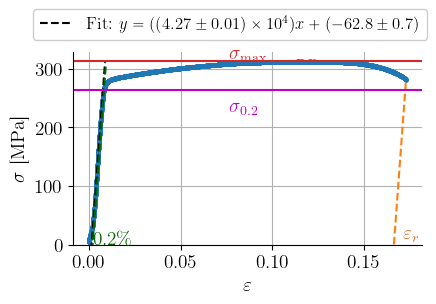

In [157]:
%matplotlib inline

name = 'froid1'

E, origin_error, s_max, eps_rup, sigma2 = \
    do_everything_fuck_it(name, froid1_data, froid1, 350, 750, hidden=True)

## Well do them

E = (5.67±0.03)×10¹⁰
Error on the origin : (5.7±0.3)×10⁶
epsilon rupture = 0.13804±0.00008
sigma 0.2 = (2.96±0.02)×10⁸


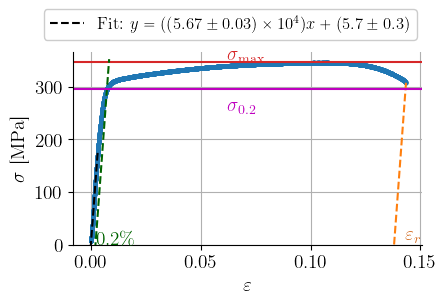

In [158]:
name = 'froid2'

E, origin_error, s_max, eps_rup, sigma2 = \
    do_everything_fuck_it(name, froid2_data, froid2, 50, 350, hidden=True)

E = (5.9±0.1)×10¹⁰
Error on the origin : (7.4±0.1)×10⁷
epsilon rupture = 0.3409±0.0002
sigma 0.2 = (8.05±0.04)×10⁷


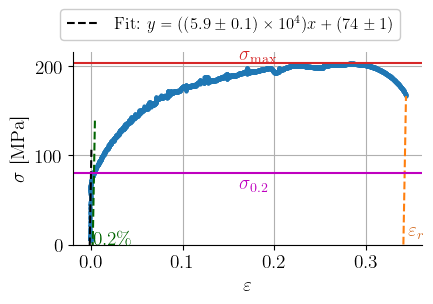

In [159]:
%matplotlib inline
name = 'chaud3'

E, origin_error, s_max, eps_rup, sigma2 = \
    do_everything_fuck_it(name, chaud3_data, chaud3, 114, 150, hidden=True)

E = (-3±1)×10¹⁰
Error on the origin : (1±2)×10⁷
epsilon rupture = 0.271±0.002
sigma 0.2 = (7.92±0.04)×10⁷


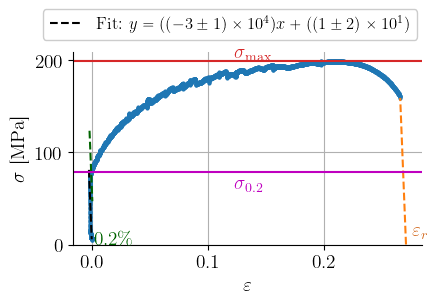

In [160]:
%matplotlib inline
# UNUSABLE BULLSHIT
name = 'chaud4'

E, origin_error, s_max, eps_rup, sigma2 = \
    do_everything_fuck_it(name, chaud4_data, chaud4, 170, 250, hidden=True)

E = (5.5±0.3)×10¹⁰
Error on the origin : (6.9±0.3)×10⁷
epsilon rupture = 0.1496±0.0002
sigma 0.2 = (1.81±0.01)×10⁸


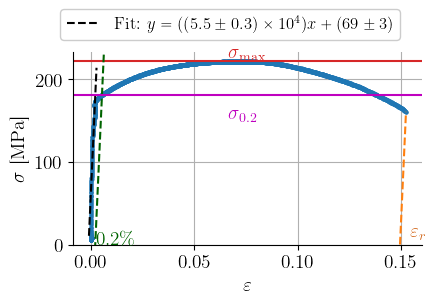

In [161]:
%matplotlib inline
name = 'tiede5'

E, origin_error, s_max, eps_rup, sigma2 = \
    do_everything_fuck_it(name, tiede5_data, tiede5, 155, 300, final_end=len(tiede5_data)-18, hidden=True)


E = (3.32±0.02)×10¹⁰
Error on the origin : (-5.0±0.1)×10⁷
epsilon rupture = 0.1587±0.0001
sigma 0.2 = (1.87±0.01)×10⁸


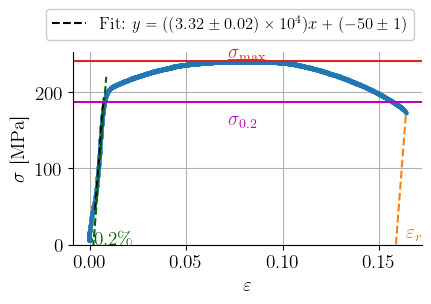

In [162]:
%matplotlib inline
### BEST
name = 'tiede6'

E, origin_error, s_max, eps_rup, sigma2 = \
    do_everything_fuck_it(name, tiede6_data, tiede6, 170, 230, final_end=len(tiede6_data)-8, hidden=True)


E = (1.54±0.03)×10¹⁰
Error on the origin : (4.2±0.1)×10⁷
epsilon rupture = 0.1150±0.0002
sigma 0.2 = (1.85±0.01)×10⁸


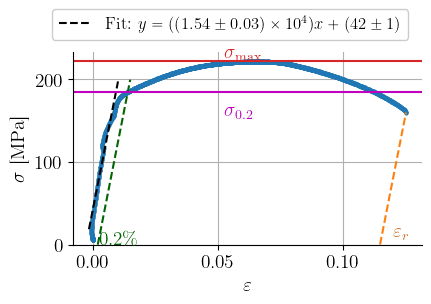

In [163]:
%matplotlib inline
name = 'tiede7'

E, origin_error, s_max, eps_rup, sigma2 = \
    do_everything_fuck_it(name, tiede7_data, tiede7, 240, 390, final_end=len(tiede7_data)-14, hidden=True)


## C-C-C-C-C-C-C-COMBO

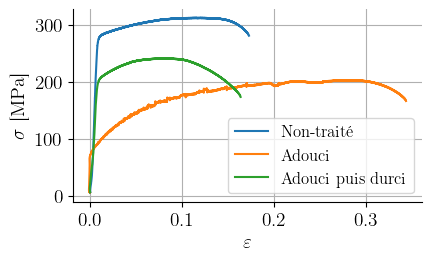

In [164]:
eps, sigma = convert(froid1_data, froid1)
plt.plot(nom_vals(eps), nom_vals(sigma)/1e6, '-', markersize=2, label='Non-traité')

eps, sigma = convert(chaud3_data, chaud3)
plt.plot(nom_vals(eps), nom_vals(sigma)/1e6, '-', markersize=2, label='Adouci')

eps, sigma = convert(tiede6_data, tiede6)
plt.plot(nom_vals(eps)[0:len(tiede6_data)-8], nom_vals(sigma)[0:len(tiede6_data)-8]/1e6, '-', markersize=2, label='Adouci puis durci')

plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'$\sigma$ [MPa]')
plt.grid()
plt.legend()
plt.savefig('../figures/comparaison.pdf')